## Design matrix for sub-trial HMM

In [4]:
import os
import numpy as np
from one.api import ONE
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import brainbox.behavior.wheel as wh
from scipy.stats import zscore
import concurrent.futures

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')
# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from video_functions import get_raw_and_smooth_position, get_dlc_XYs, get_lick_times, get_pupil_diameter, get_ME, keypoint_speed, pupil_center, nose_tip, left_paw, right_paw
from design_functions import lick_rate, wheel_velocity, wheel_displacement, pupil_diam, cont_bin

In [2]:
# one = ONE(base_url='https://alyx.internationalbrainlab.org')
# one.alyx.rest('sessions', 'list')
# # one.setup()

### Get sessions from mice of interest

In [5]:
# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video and wheel/'
# data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video and wheel/'

os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions_metadata", "rb"))
pass_qc = pickle.load(open(data_path + "good_dlc_bwm_sessions_metadata", "rb"))
# mouse_names = pass_qc['subject_nickname'].unique()

In [3]:
len(pass_qc)

176

### Parameters

In [4]:
bin_size = 0.1  # seconds
video_type = 'left'    

## Compute frame rate per session

In [20]:
frame_rate = pass_qc.copy()
frame_rate['frame_rate'] = np.zeros(len(pass_qc)) * np.nan
for s, session in enumerate(pass_qc['session_uuid']):
    try:
        
        mouse_name = pass_qc['subject_nickname'][s]
        dlc_times, XYs = get_dlc_XYs(one, session, view=video_type, likelihood_thresh=0.9)
        frt = 1/np.mean(np.diff(dlc_times))
        
        # Save
        frame_rate.loc[(frame_rate['subject_nickname']==mouse_name) & 
                       (frame_rate['session_uuid']==session), 'frame_rate'] = frt

    except:
       print(session)

# Save design matrix
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/frame_rate/'
os.chdir(data_path)
pickle.dump(frame_rate, open("frame_rate", "wb"))

# Run code in parallel

In [17]:
# Loop through animals
function_name = process_design_matrix
sessions = pass_qc['session_uuid']
# sessions = list(pass_qc.loc[pass_qc['subject_nickname']=='CSHL045', 'session_uuid'])
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v4_5Jul2024/' + str(bin_size) + '/'
os.chdir(data_path)
files = os.listdir()
for s, sess in enumerate(sessions):
    mouse_name = list(pass_qc.loc[pass_qc['session_uuid']==sess, 'subject_nickname'])[0]
    filename = "design_matrix_" + str(sess) + '_'  + mouse_name + '_' + str(bin_size)
    if filename not in files:
        parallel_process_data([sess], function_name)

d32876dd-8303-4720-8e7e-20678dc2fd71
72982282-e493-45ee-87ce-aa45cb3a3ec1
6434f2f5-6bce-42b8-8563-d93d493613a2
64e3fb86-928c-4079-865c-b364205b502e
15948667-747b-4702-9d53-354ac70e9119
288bfbf3-3700-4abe-b6e4-130b5c541e61
fc43390d-457e-463a-9fd4-b94a0a8b48f5
3d59aa1a-b4ba-47fe-b9cf-741b5fdb0c7b
6364ff7f-6471-415a-ab9e-632a12052690


local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.bc2892ec-a74f-4697-ab1f-42ccf0a00443.npy Bytes: 5384


100%|██████████| 0.00513458251953125/0.00513458251953125 [00:00<00:00,  1.70s/it]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.624b4901-d15f-40b4-97af-f9f72d74a51c.npy Bytes: 5352


100%|██████████| 0.00510406494140625/0.00510406494140625 [00:00<00:00,  1.29it/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-08/001/alf/_ibl_trials.goCueTrigger_times.npy


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-08/001/alf/_ibl_trials.goCueTrigger_times.60917ccf-cc92-4430-9006-81ee13118d9d.npy Bytes: 6528


100%|██████████| 0.0062255859375/0.0062255859375 [00:00<00:00,  1.35it/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.16c81eaf-a032-49cd-9823-09c0c7350fd2.npy Bytes: 5256


100%|██████████| 0.00501251220703125/0.00501251220703125 [00:00<00:00,  1.15it/s]


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-11/001/alf/#2024-07-15#/_ibl_trials.stimOffTrigger_times.9b98c742-59d2-40d4-a3ec-de60cbb8bded.npy Bytes: 3952
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-11/001/alf/#2024-07-15#/_ibl_trials.stimOnTrigger_times.41977da1-f395-4c59-b525-41be3b3d1032.npy Bytes: 3952


100%|██████████| 0.0037689208984375/0.0037689208984375 [00:00<00:00,  3.52s/it]
100%|██████████| 0.0037689208984375/0.0037689208984375 [00:00<00:00,  2.70s/it]


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-11/001/alf/#2024-07-15#/_ibl_trials.table.12ddae0c-b285-4100-8d06-5e2cde23efe4.pqt Bytes: 41394


  0%|          | 0/0.03947639465332031 [00:00<?, ?it/s]

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-11/001/alf/#2024-07-15#/_ibl_trials.stimOff_times.87c297e1-fd1f-4d4f-9e8d-73b4a77339a4.npy Bytes: 3952


100%|██████████| 0.0037689208984375/0.0037689208984375 [00:00<00:00,  1.72s/it]
100%|██████████| 0.03947639465332031/0.03947639465332031 [00:00<00:00,  6.89s/it]


b22f694e-4a34-4142-ab9d-2556c3487086
90d1e82c-c96f-496c-ad4e-ee3f02067f25
68775ca0-b056-48d5-b6ae-a4c2a76ae48f
1b61b7f2-a599-4e40-abd6-3e758d2c9e25


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a
d7e60cc3-6020-429e-a654-636c6cc677ea
113c5b6c-940e-4b21-b462-789b4c2be0e5
d0c91c3c-8cbb-4929-8657-31f18bffc294
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02373/2021-06-23/001/alf/#2024-07-15#/_ibl_trials.table.0d2c5d9c-8504-49f5-9869-01deafadffab.pqt Bytes: 37866
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02373/2021-06-23/001/alf/#2024-07-15#/_ibl_trials.stimOnTrigger_times.242db3e0-b786-4872-af4b-c6b38d8ce7d7.npy Bytes: 3520


100%|██████████| 0.00335693359375/0.00335693359375 [00:00<00:00,  2.72s/it]

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02373/2021-06-23/001/alf/#2024-07-15#/_ibl_trials.stimOffTrigger_times.8995d9e2-8f9c-4588-bc54-28df41a6ef12.npy Bytes: 3520
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02373/2021-06-23/001/alf/#2024-07-15#/_ibl_trials.stimOff_times.ad538c37-b49c-487c-8eb3-56b34dc15ff8.npy Bytes: 3520






100%|██████████| 0.00335693359375/0.00335693359375 [00:00<00:00,  1.45s/it]
100%|██████████| 0.00335693359375/0.00335693359375 [00:00<00:00,  1.45it/s]
100%|██████████| 0.03611183166503906/0.03611183166503906 [00:00<00:00,  7.44s/it]


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_038/2020-08-01/001/alf/#2024-07-15#/_ibl_trials.stimOffTrigger_times.8111b093-62fc-4571-b85f-df7584beeb7c.npy Bytes: 7064
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_038/2020-08-01/001/alf/#2024-07-15#/_ibl_trials.table.162fe3af-1337-494b-a8ad-3c392751e2fb.pqt Bytes: 66658


  0%|          | 0/0.00673675537109375 [00:00<?, ?it/s]

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_038/2020-08-01/001/alf/#2024-07-15#/_ibl_trials.stimOff_times.accbfe5b-12ac-43c9-9f01-90453abb2d97.npy Bytes: 7064
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_038/2020-08-01/001/alf/#2024-07-15#/_ibl_trials.stimOnTrigger_times.485cd50d-2dff-4bed-8abc-2e9ffabb564b.npy Bytes: 7064


100%|██████████| 0.00673675537109375/0.00673675537109375 [00:00<00:00,  2.08it/s]



100%|██████████| 0.00673675537109375/0.00673675537109375 [00:00<00:00,  2.84it/s]
100%|██████████| 0.00673675537109375/0.00673675537109375 [00:00<00:00,  4.65it/s]
100%|██████████| 0.06357002258300781/0.06357002258300781 [00:00<00:00,  4.87s/it]


fc14c0d6-51cf-48ba-b326-56ed5a9420c3
22e04698-b974-4805-b241-3b547dbf37bf
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0027/2022-08-22/001/alf/#2024-07-15#/_ibl_trials.stimOnTrigger_times.141af070-0d8d-402c-a2b6-07a676b87e7a.npy Bytes: 9656
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0027/2022-08-22/001/alf/#2024-07-15#/_ibl_trials.table.9b96ebd5-baa8-4f82-854b-bba25e481cd2.pqt Bytes: 89876
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0027/2022-08-22/001/alf/#2024-07-15#/_ibl_trials.stimOff_times.770c4d55-8136-4cff-86e1-f5621e90cb32.npy Bytes: 9656
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0027/2022-08-22/001/alf/#2024-07-15#/_ibl_trials.stimOffTrigger_times.5b1591b8-015a-470a-9d23-1a8853cc0c0a.npy Bytes: 9656


  0%|          | 0/0.00920867919921875 [00:00<?, ?it/s]


100%|██████████| 0.00920867919921875/0.00920867919921875 [00:00<00:00,  1.79it/s]
100%|██████████| 0.00920867919921875/0.00920867919921875 [00:00<00:00,  1.28s/it]
100%|██████████| 0.00920867919921875/0.00920867919921875 [00:00<00:00,  3.15it/s]
100%|██████████| 0.08571243286132812/0.08571243286132812 [00:00<00:00,  5.31s/it]


09394481-8dd2-4d5c-9327-f2753ede92d7
Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-09/002/alf/#2024-07-15#/_ibl_trials.table.d23becf3-4d56-49a7-9bc9-03d63c092872.pqt Bytes: 47528


  0%|          | 0/0.04532623291015625 [00:00<?, ?it/s]

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-09/002/alf/#2024-07-15#/_ibl_trials.stimOnTrigger_times.626c8ca4-d274-4e2e-bb8a-3fca5c0ece42.npy Bytes: 4632


100%|██████████| 0.00441741943359375/0.00441741943359375 [00:00<00:00,  1.09s/it]


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-09/002/alf/#2024-07-15#/_ibl_trials.stimOff_times.ec4d2e83-6966-4e22-b32f-8d68c44ebe2f.npy Bytes: 4632


100%|██████████| 0.00441741943359375/0.00441741943359375 [00:00<00:00,  2.16it/s]
100%|██████████| 0.04532623291015625/0.04532623291015625 [00:00<00:00,  6.49s/it]


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-09/002/alf/#2024-07-15#/_ibl_trials.stimOffTrigger_times.910276d1-dd24-43cd-ac4b-c5efc58b5c58.npy Bytes: 4632


100%|██████████| 0.00441741943359375/0.00441741943359375 [00:00<00:00,  1.31it/s]


In [9]:
# Loop through animals
function_name = process_design_matrix
sessions = pass_qc['session_uuid']
loop_times = int(np.ceil(len(sessions)/5))  # tried to run 10 sessions in parallel but it breaks

for l in range(loop_times):
    start_idx = l*5
    end_idx = l*5+5
    use_sessions = sessions[start_idx:end_idx]
    parallel_process_data(use_sessions, function_name)

64e3fb86-928c-4079-865c-b364205b502e
d32876dd-8303-4720-8e7e-20678dc2fd71
6434f2f5-6bce-42b8-8563-d93d493613a2
15948667-747b-4702-9d53-354ac70e9119
72982282-e493-45ee-87ce-aa45cb3a3ec1
288bfbf3-3700-4abe-b6e4-130b5c541e61
fc43390d-457e-463a-9fd4-b94a0a8b48f5
3d59aa1a-b4ba-47fe-b9cf-741b5fdb0c7b


local md5 mismatch on dataset: churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.60k/4.60k [00:00<00:00, 7.21kB/s]


6364ff7f-6471-415a-ab9e-632a12052690


local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.38k/4.38k [00:00<00:00, 7.10kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-08/001/alf/_ibl_trials.goCueTrigger_times.npy
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy
local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy:   0%|          | 0.00/5.35k [00:00<?, ?B/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.35k/5.35k [00:00<00:00, 9.97kB/s]

/

: 

: 

# Design Matrix V4 9 Dec 2024

- Same as V4 but only includes wheel velocity, licks and whisker motion energy

In [ ]:
def process_design_matrix(session):
    bin_size = 0.1
    
    mouse_name = list(pass_qc.loc[pass_qc['session_uuid']==session, 'subject_nickname'])[0]

    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()

    # Licks
    session_licks = get_lick_times(one, session, combine=False, video_type=video_type)

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)
    
    # Motion energy of whisker pad
    me_times, motion_energy = get_ME(one, session, video_type)       
    motion_energy = zscore(motion_energy, nan_policy='omit') 


    # Initialize dataframe
    licking = lick_rate(bin_size, session_licks, session_trials)
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
    wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=True)
    whisker_me = cont_bin(me_times, motion_energy, session_trials, bin_size)

    # Rename column names
    whisker_me = whisker_me.rename(columns={'Values':'whisker_me'})
    
    # Merge all tables
    all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].dropna().merge(licking[['Bin', 'Lick count']], on='Bin', how='outer')
    all_metrics = all_metrics.merge(wheel_disp[['Bin', 'wheel_final']], on='Bin', how='outer')
    all_metrics = all_metrics.merge(whisker_me[['Bin', 'whisker_me']], on='Bin', how='outer')

    # Remove Nans before adding more data or else this breaks (not sure if this is really tru, but worked like this)
    all_metrics['Lick count'] = all_metrics['Lick count'].replace(np.NaN, 0)
    all_metrics = all_metrics.dropna().drop_duplicates()

    # Save design matrix
    data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v5_9Dec2024/' + str(bin_size) + '/'
    os.chdir(data_path)
    pickle.dump(all_metrics, open("design_matrix_" + str(session) + '_'  + mouse_name + '_' + str(bin_size), "wb"))


def parallel_process_data(sessions, function_name):
    with concurrent.futures.ThreadPoolExecutor() as executor:

        # Process each chunk in parallel
        executor.map(function_name, sessions)

# Design Matrix V4 5 Jul 2024

- V3 includes data to be used on 'movement detector' 2ARHMMs
- Includes no pupil data because it is not trustworthy
- Includes the two paws

In [5]:
def process_design_matrix(session):
    bin_size = 0.1
    try:
        
        mouse_name = list(pass_qc.loc[pass_qc['session_uuid']==session, 'subject_nickname'])[0]

        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()

        # Licks
        session_licks = get_lick_times(one, session, combine=False, video_type=video_type)

        # Wheel
        wheel = one.load_object(session, 'wheel', collection='alf')
        pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

        # # Pupil diameter
        # pupil_dia_raw, pupil_dia_smooth, _, _ = (
        #     get_raw_and_smooth_position(one, session, video_type, ephys=True, position_function=get_pupil_diameter))
        dlc_times, XYs = get_dlc_XYs(one, session, view=video_type, likelihood_thresh=0.9)
        
        # # Pupil position
        # pupil_X, pupil_Y = pupil_center(XYs)
        
        # Motion energy of whisker pad
        me_times, motion_energy = get_ME(one, session, video_type)       
        motion_energy = zscore(motion_energy, nan_policy='omit') 
        
        # Nose positions
        nose_X, nose_Y = nose_tip(XYs)

        # Left paw positions
        left_paw_X, left_paw_Y = left_paw(XYs)
        
        # Right paw positions
        right_paw_X, right_paw_Y = right_paw(XYs)
        
        # Get session values
        # session_length = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        # n_bins = int(np.floor(session_length/bin_size))
        # onsets = session_trials['stimOn_times']

        # Initialize dataframe
        licking = lick_rate(bin_size, session_licks, session_trials)
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=True)
        # pupil_dia = pupil_diam(dlc_times, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=True)
        whisker_me = cont_bin(me_times, motion_energy, session_trials, bin_size)
        left_X = cont_bin(dlc_times, left_paw_X, session_trials, bin_size)
        left_Y = cont_bin(dlc_times, left_paw_Y, session_trials, bin_size)
        right_X = cont_bin(dlc_times, right_paw_X, session_trials, bin_size)
        right_Y = cont_bin(dlc_times, right_paw_Y, session_trials, bin_size)
        # pupil_X_pos = cont_bin(dlc_times, pupil_X, session_trials, bin_size)
        # pupil_Y_pos = cont_bin(dlc_times, pupil_Y, session_trials, bin_size)
        nose_X_pos = cont_bin(dlc_times, nose_X, session_trials, bin_size)
        nose_Y_pos = cont_bin(dlc_times, nose_Y, session_trials, bin_size)
        
        # Rename column names
        # pupil_dia = pupil_dia.rename(columns={'pupil_final':'pupil_diameter'})
        whisker_me = whisker_me.rename(columns={'Values':'whisker_me'})
        left_X = left_X.rename(columns={'Values':'left_X'})
        left_Y = left_Y.rename(columns={'Values':'left_Y'})
        right_X = right_X.rename(columns={'Values':'right_X'})
        right_Y = right_Y.rename(columns={'Values':'right_Y'})
        # pupil_X_pos = pupil_X_pos.rename(columns={'Values':'pupil_X'})
        # pupil_Y_pos = pupil_Y_pos.rename(columns={'Values':'pupil_Y'})   
        nose_X_pos = nose_X_pos.rename(columns={'Values':'nose_X'})
        nose_Y_pos = nose_Y_pos.rename(columns={'Values':'nose_Y'})     
        
        # Merge all tables
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].dropna().merge(licking[['Bin', 'Lick count']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(wheel_disp[['Bin', 'wheel_final']], on='Bin', how='outer')
        # all_metrics = all_metrics.merge(pupil_dia[['Bin', 'pupil_diameter']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(whisker_me[['Bin', 'whisker_me']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_X[['Bin', 'left_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_Y[['Bin', 'left_Y']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(right_X[['Bin', 'right_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(right_Y[['Bin', 'right_Y']], on='Bin', how='outer')
        # all_metrics = all_metrics.merge(pupil_X_pos[['Bin', 'pupil_X']], on='Bin', how='outer')
        # all_metrics = all_metrics.merge(pupil_Y_pos[['Bin', 'pupil_Y']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(nose_X_pos[['Bin', 'nose_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(nose_Y_pos[['Bin', 'nose_Y']], on='Bin', how='outer')

        # Remove Nans before adding more data or else this breaks (not sure if this is really tru, but worked like this)
        all_metrics['Lick count'] = all_metrics['Lick count'].replace(np.NaN, 0)
        all_metrics = all_metrics.dropna().drop_duplicates()

        # Save design matrix
        data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v4_5Jul2024/' + str(bin_size) + '/'
        os.chdir(data_path)
        pickle.dump(all_metrics, open("design_matrix_" + str(session) + '_'  + mouse_name + '_' + str(bin_size), "wb"))

    except:
       print(session)

def parallel_process_data(sessions, function_name):
    with concurrent.futures.ThreadPoolExecutor() as executor:

        # Process each chunk in parallel
        executor.map(function_name, sessions)

# Design Matrix V3

- V3 includes data to be used on 'movement detector' 2ARHMMs

In [4]:
def process_design_matrix(session):
    bin_size = 0.1
    try:
        
        mouse_name = list(pass_qc.loc[pass_qc['session_uuid']==session, 'subject_nickname'])[0]

        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()

        # Licks
        session_licks = get_lick_times(one, session, combine=False, video_type=video_type)

        # Wheel
        wheel = one.load_object(session, 'wheel', collection='alf')
        pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

        # Pupil diameter
        pupil_dia_raw, pupil_dia_smooth, _, _ = (
            get_raw_and_smooth_position(one, session, video_type, ephys=True, position_function=get_pupil_diameter))
        dlc_times, XYs = get_dlc_XYs(one, session, view=video_type, likelihood_thresh=0.9)
        
        # Pupil position
        pupil_X, pupil_Y = pupil_center(XYs)
        
        # Motion energy of whisker pad
        me_times, motion_energy = get_ME(one, session, video_type)       
        motion_energy = zscore(motion_energy, nan_policy='omit') 
        
        # Nose positions
        nose_X, nose_Y = nose_tip(XYs)

        # Left paw positions
        left_paw_X, left_paw_Y = left_paw(XYs)
        
        # Right paw positions
        right_paw_X, right_paw_Y = right_paw(XYs)
        
        # Get session values
        session_length = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        n_bins = int(np.floor(session_length/bin_size))
        onsets = session_trials['stimOn_times']

        # Initialize dataframe
        licking = lick_rate(bin_size, session_licks, session_trials)
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=True)
        pupil_dia = pupil_diam(dlc_times, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=True)
        whisker_me = cont_bin(me_times, motion_energy, session_trials, bin_size)
        left_X = cont_bin(dlc_times, left_paw_X, session_trials, bin_size)
        left_Y = cont_bin(dlc_times, left_paw_Y, session_trials, bin_size)
        right_X = cont_bin(dlc_times, right_paw_X, session_trials, bin_size)
        right_Y = cont_bin(dlc_times, right_paw_Y, session_trials, bin_size)
        pupil_X_pos = cont_bin(dlc_times, pupil_X, session_trials, bin_size)
        pupil_Y_pos = cont_bin(dlc_times, pupil_Y, session_trials, bin_size)
        nose_X_pos = cont_bin(dlc_times, nose_X, session_trials, bin_size)
        nose_Y_pos = cont_bin(dlc_times, nose_Y, session_trials, bin_size)
        
        # Rename column names
        pupil_dia = pupil_dia.rename(columns={'pupil_final':'pupil_diameter'})
        whisker_me = whisker_me.rename(columns={'Values':'whisker_me'})
        left_X = left_X.rename(columns={'Values':'left_X'})
        left_Y = left_Y.rename(columns={'Values':'left_Y'})
        right_X = right_X.rename(columns={'Values':'right_X'})
        right_Y = right_Y.rename(columns={'Values':'right_Y'})
        pupil_X_pos = pupil_X_pos.rename(columns={'Values':'pupil_X'})
        pupil_Y_pos = pupil_Y_pos.rename(columns={'Values':'pupil_Y'})   
        nose_X_pos = nose_X_pos.rename(columns={'Values':'nose_X'})
        nose_Y_pos = nose_Y_pos.rename(columns={'Values':'nose_Y'})     
        
        # Merge all tables
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].dropna().merge(licking[['Bin', 'Lick count']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(wheel_disp[['Bin', 'wheel_final']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_dia[['Bin', 'pupil_diameter']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(whisker_me[['Bin', 'whisker_me']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_X[['Bin', 'left_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_Y[['Bin', 'left_Y']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(right_X[['Bin', 'right_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(right_Y[['Bin', 'right_Y']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_X_pos[['Bin', 'pupil_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_Y_pos[['Bin', 'pupil_Y']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(nose_X_pos[['Bin', 'nose_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(nose_Y_pos[['Bin', 'nose_Y']], on='Bin', how='outer')

        # Remove Nans before adding more data or else this breaks (not sure if this is really tru, but worked like this)
        all_metrics['Lick count'] = all_metrics['Lick count'].replace(np.NaN, 0)
        all_metrics = all_metrics.dropna().drop_duplicates()

        # Save design matrix
        data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v3_5Jul2024/' + str(bin_size) + '/'
        os.chdir(data_path)
        pickle.dump(all_metrics, open("design_matrix_" + str(session) + '_'  + mouse_name + '_' + str(bin_size), "wb"))

    except:
       print(session)

def parallel_process_data(sessions, function_name):
    with concurrent.futures.ThreadPoolExecutor() as executor:

        # Process each chunk in parallel
        executor.map(function_name, sessions)

# Design matrix V1

In [4]:
for s, session in enumerate(pass_qc['session_uuid'][0:1]):
    # TODO: as it is this takes ~10 minutes!! Mostly because of smoothing, outlier removal, ... of timeseries
    
    try:
        mouse_name = pass_qc['subject_nickname'][s]
        
        # Trials data
        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()

        # Licks
        session_licks = get_lick_times(one, session, combine=False, video_type=video_type)

        # Wheel
        wheel = one.load_object(session, 'wheel', collection='alf')
        pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

        # Pupil diameter
        pupil_dia_raw, pupil_dia_smooth, _, _ = (
            get_raw_and_smooth_position(one, session, video_type, ephys=True, position_function=get_pupil_diameter))
        pupil_t, XYs = get_dlc_XYs(one, session, view=video_type, likelihood_thresh=0.9)

        # Motion energy of whisker pad
        me_times, motion_energy = get_ME(one, session, video_type)       
        #motion_energy = zscore(motion_energy, nan_policy='omit') 

        # Nose velocity
        nose_speeds = keypoint_speed(one, session, True, 'nose_tip', True)
        nose_times = nose_speeds['left'][0][1:]
        nose_speed_X = nose_speeds['left'][1]
        nose_speed_Y = nose_speeds['left'][2]

        # Left paw velocity
        left_p_speeds = keypoint_speed(one, session, True, 'paw_r', True)
        left_p_times = left_p_speeds['left'][0][1:]
        left_p_speed_X = left_p_speeds['left'][1]
        left_p_speed_Y = left_p_speeds['left'][2]

        # Pupil velocity
        pupil_speeds = keypoint_speed(one, session, True, pupil_center, True)
        pupil_times = pupil_speeds['left'][0][1:]
        pupil_speed_X = pupil_speeds['left'][1]
        pupil_speed_Y = pupil_speeds['left'][2]
        
        
        session_length = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        n_bins = int(np.floor(session_length/bin_size))
        onsets = session_trials['stimOn_times']

        # Initialize dataframe
        licking = lick_rate(bin_size, session_licks, session_trials)
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)
        pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=True)
        whisker_me = cont_bin(me_times, motion_energy, session_trials, bin_size)
        nose_vel_X = cont_bin(nose_times, nose_speed_X, session_trials, bin_size)
        nose_vel_Y = cont_bin(nose_times, nose_speed_Y, session_trials, bin_size)
        left_vel_X = cont_bin(left_p_times, left_p_speed_X, session_trials, bin_size)
        left_vel_Y = cont_bin(left_p_times, left_p_speed_Y, session_trials, bin_size)
        pupil_vel_X = cont_bin(pupil_times, pupil_speed_X, session_trials, bin_size)
        pupil_vel_Y = cont_bin(pupil_times, pupil_speed_Y, session_trials, bin_size)
        
        pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})
        whisker_me = whisker_me.rename(columns={'Values':'whisker_me'})
        nose_vel_X = nose_vel_X.rename(columns={'Values':'nose_speed_X'})
        nose_vel_Y = nose_vel_Y.rename(columns={'Values':'nose_speed_Y'})
        left_vel_X = left_vel_X.rename(columns={'Values':'l_paw_speed_X'})
        left_vel_Y = left_vel_Y.rename(columns={'Values':'l_paw_speed_Y'})
        pupil_vel_X = pupil_vel_X.rename(columns={'Values':'pupil_speed_X'})
        pupil_vel_Y = pupil_vel_Y.rename(columns={'Values':'pupil_speed_Y'})
        
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].dropna().merge(licking[['Bin', 'Lick count']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(whisker_me[['Bin', 'whisker_me']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(nose_vel_X[['Bin', 'nose_speed_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(nose_vel_Y[['Bin', 'nose_speed_Y']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_vel_X[['Bin', 'l_paw_speed_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_vel_Y[['Bin', 'l_paw_speed_Y']], on='Bin', how='outer')

        # Remove Nans before adding more data or else this breaks (not sure if this is really tru, but worked like this)
        all_metrics['Lick count'] = all_metrics['Lick count'].replace(np.NaN, 0)
        all_metrics = all_metrics.dropna().drop_duplicates()

        new = all_metrics.merge(pupil_vel_X[['Bin', 'pupil_speed_X']], on='Bin', how='outer')
        new = new.merge(pupil_vel_Y[['Bin', 'pupil_speed_Y']], on='Bin', how='outer')

        all_metrics = new.copy()
        all_metrics = all_metrics.dropna().drop_duplicates()

        # Transform licks
        def anscombe_transform(x):
            return 2 * np.sqrt(x + 3/8)
        all_metrics['Gaussian_licks'] = anscombe_transform(all_metrics['Lick count'])
        all_metrics['Gaussian_licks'] = np.sqrt(all_metrics['Lick count'])

        # Save design matrix
        data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix' + str(bin_size) + '/'
        os.chdir(data_path)
        pickle.dump(all_metrics, open("design_matrix_" + str(session) + '_' + mouse_name + str(bin_size), "wb"))
        
    except:
        print(session)

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


7af49c00-63dd-4fed-b2e0-1b3bd945b20b


In [13]:
for s, session in enumerate(pass_qc['session_uuid']):
    # TODO: as it is this takes ~10 minutes!! Mostly because of smoothing, outlier removal, ... of timeseries
    
    try:
        mouse_name = pass_qc['subject_nickname'][s]

        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()

        # Get session values
        session_length = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        n_bins = int(np.floor(session_length/bin_size))
        onsets = session_trials['stimOn_times']

        # Licks
        session_licks = get_lick_times(session, combine=False, video_type=video_type)

        # Wheel
        wheel = one.load_object(session, 'wheel', collection='alf')
        pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

        # Pupil diameter
        pupil_dia_raw, pupil_dia_smooth, _, _ = (
            get_raw_and_smooth_position(session, video_type, ephys=True, position_function=get_pupil_diameter))
        dlc_times, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)
        
        # Pupil position
        pupil_X, pupil_Y = pupil_center(XYs)
        
        # Motion energy of whisker pad
        me_times, motion_energy = get_ME(session, video_type)       
        #motion_energy = zscore(motion_energy, nan_policy='omit') 

        # Nose velocity
        nose_speeds = keypoint_speed(session, True, 'nose_tip', False)
        nose_times = nose_speeds['left'][0][1:]
        nose_speed = nose_speeds['left'][1]
        #nose_X, nose_Y = nose_tip(XYs)
        
        # Left paw velocity
        left_p_speeds = keypoint_speed(session, True, 'paw_r', False)
        left_p_times = left_p_speeds['left'][0][1:]
        left_p_speed = left_p_speeds['left'][1]

        # Left paw positions
        left_paw_X, left_paw_Y = left_paw(XYs)
        
        # Pupil velocity
        pupil_speeds = keypoint_speed(session, True, pupil_center, False)
        pupil_times = pupil_speeds['left'][0][1:]
        pupil_speed = pupil_speeds['left'][1]

        # Initialize dataframe
        licking = lick_rate(bin_size, session_licks, session_trials)
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)
        pupil_dia = pupil_diam(dlc_times, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=True)
        whisker_me = cont_bin(me_times, motion_energy, session_trials, bin_size)
        nose_vel = cont_bin(nose_times, nose_speed, session_trials, bin_size)
        left_vel = cont_bin(left_p_times, left_p_speed, session_trials, bin_size)
        left_X = cont_bin(dlc_times, left_paw_X, session_trials, bin_size)
        left_Y = cont_bin(dlc_times, left_paw_Y, session_trials, bin_size)
        pupil_vel = cont_bin(pupil_times, pupil_speed, session_trials, bin_size)
        pupil_X_pos = cont_bin(dlc_times, pupil_X, session_trials, bin_size)
        pupil_Y_pos = cont_bin(dlc_times, pupil_Y, session_trials, bin_size)
        
        # Rename column names
        pupil_dia = pupil_dia.rename(columns={'pupil_final':'pupil_diameter'})
        whisker_me = whisker_me.rename(columns={'Values':'whisker_me'})
        nose_vel = nose_vel.rename(columns={'Values':'nose_speed'})
        left_vel = left_vel.rename(columns={'Values':'l_paw_speed'})
        left_X = left_X.rename(columns={'Values':'left_X'})
        left_Y = left_Y.rename(columns={'Values':'left_Y'})
        pupil_vel = pupil_vel.rename(columns={'Values':'pupil_speed'})
        pupil_X_pos = pupil_X_pos.rename(columns={'Values':'pupil_X'})
        pupil_Y_pos = pupil_Y_pos.rename(columns={'Values':'pupil_Y'})     
        
        
        # Merge all tables
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].dropna().merge(licking[['Bin', 'Lick count']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_dia[['Bin', 'pupil_diameter']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(whisker_me[['Bin', 'whisker_me']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(nose_vel[['Bin', 'nose_speed']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_vel[['Bin', 'l_paw_speed']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_X[['Bin', 'left_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_Y[['Bin', 'left_Y']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_vel[['Bin', 'pupil_speed']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_X_pos[['Bin', 'pupil_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_Y_pos[['Bin', 'pupil_Y']], on='Bin', how='outer')

        # Remove Nans before adding more data or else this breaks (not sure if this is really tru, but worked like this)
        all_metrics['Lick count'] = all_metrics['Lick count'].replace(np.NaN, 0)

    except:
        print(str(mouse_name + ' missing'))

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-40/2021-04-16/002/alf/leftCamera.ROIMotionEnergy.751b92f8-44b7-4081-86d2-3ce9cd31b9e0.npy Bytes: 1693288


100%|██████████| 1.6148452758789062/1.6148452758789062 [00:01<00:00,  1.48it/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/autograd

NYU-46 missing
NYU-46 missing
NYU-47 missing
NYU-47 missing


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/#2023-04-20#/_ibl_leftCamera.times.b0e0b0e8-70bc-41db-877d-607e65b179f1.npy Bytes: 2749112


100%|██████████| 2.6217575073242188/2.6217575073242188 [00:01<00:00,  1.69it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/leftCamera.ROIMotionEnergy.dbcd735a-00f5-498c-83e4-2d159d5722f5.npy Bytes: 2749112


100%|██████████| 2.6217575073242188/2.6217575073242188 [00:09<00:00,  3.48s/it]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/#2023-04-20#/_ibl_rightCamera.times.7fb81847-7a7b-4a35-b588-fe32daa7856a.npy Bytes: 6886512


100%|██████████| 6.5674896240234375/6.5674896240234375 [00:05<00:00,  1.21it/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)


CSHL060 missing
KS051 missing


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)


KS096 missing
DY_013 missing


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-19/001/alf/#2023-04-20#/_ibl_leftCamera.times.1de68cf0-788d-4910-bfc3-703cc57e42a0.npy Bytes: 2248304


100%|██████████| 2.1441497802734375/2.1441497802734375 [00:01<00:00,  1.77it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-19/001/alf/leftCamera.ROIMotionEnergy.b6b500d3-3a03-41d9-b2d7-62bda85a4bd6.npy Bytes: 2248304


100%|██████████| 2.1441497802734375/2.1441497802734375 [00:02<00:00,  1.01it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-19/001/alf/#2023-04-20#/_ibl_rightCamera.times.02899bf3-fb54-4418-886c-183a086a1466.npy Bytes: 5629672


100%|██████████| 5.368873596191406/5.368873596191406 [00:02<00:00,  2.35it/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/autograd/t

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-11/001/alf/leftCamera.ROIMotionEnergy.2e7316bb-b786-42cc-8d09-25ba880209a4.npy Bytes: 1987328


100%|██████████| 1.895263671875/1.895263671875 [00:02<00:00,  1.08s/it]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/autograd/tracer.

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-15/001/alf/leftCamera.ROIMotionEnergy.fa345cf3-2b12-4cfd-bc8b-c44daea35cf8.npy Bytes: 1911480


100%|██████████| 1.8229293823242188/1.8229293823242188 [00:01<00:00,  1.60it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-15/001/alf/_ibl_rightCamera.times.9c06aa1e-5964-404d-a594-c1ba934dec5b.npy Bytes: 4786072


100%|██████████| 4.564353942871094/4.564353942871094 [00:01<00:00,  2.35it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-15/001/alf/_ibl_rightCamera.dlc.4e5a8055-b79a-4f54-b1d5-14eaa0ff32f0.pqt Bytes: 80059087


100%|██████████| 76.3502950668335/76.3502950668335 [01:07<00:00,  1.12it/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/na

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL015/2022-02-21/002/alf/leftCamera.ROIMotionEnergy.e075a942-ba1c-487f-8fc5-770f35db2630.npy Bytes: 1350400


100%|██████████| 1.287841796875/1.287841796875 [00:01<00:00,  1.23it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL015/2022-02-21/002/alf/_ibl_rightCamera.times.eef8fbf5-0c20-4cf6-b578-17ffadbeeb71.npy Bytes: 3372656


100%|██████████| 3.2164154052734375/3.2164154052734375 [00:01<00:00,  2.34it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL015/2022-02-21/002/alf/_ibl_rightCamera.dlc.12e54c19-e9a7-451a-ad8f-e9b37d0abc9a.pqt Bytes: 58822317


100%|██████████| 56.09733295440674/56.09733295440674 [00:08<00:00,  6.26it/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/autograd/t

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL016/2022-01-17/001/alf/leftCamera.ROIMotionEnergy.f5f6bfa6-c760-4730-8e30-b1f50e787cd2.npy Bytes: 1528600


100%|██████████| 1.4577865600585938/1.4577865600585938 [00:01<00:00,  1.24it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL016/2022-01-17/001/alf/_ibl_rightCamera.times.1fae8360-8da3-498e-9ee3-47657c47d92d.npy Bytes: 3817728


100%|██████████| 3.640869140625/3.640869140625 [00:01<00:00,  2.65it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL016/2022-01-17/001/alf/_ibl_rightCamera.dlc.a1740514-fddf-40af-9bb5-7815f79b3d51.pqt Bytes: 69588608


100%|██████████| 66.3648681640625/66.3648681640625 [00:08<00:00,  7.45it/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/autograd/tra

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-09/001/alf/leftCamera.ROIMotionEnergy.b6077dc6-b332-495c-b673-e2095732bbcd.npy Bytes: 2121992


100%|██████████| 2.0236892700195312/2.0236892700195312 [00:01<00:00,  1.55it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-09/001/alf/_ibl_rightCamera.times.25098918-6864-42b7-98b0-3e1f563297cb.npy Bytes: 5299824


100%|██████████| 5.0543060302734375/5.0543060302734375 [00:01<00:00,  3.17it/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-09/001/alf/_ibl_rightCamera.dlc.b39e2fea-5c35-4e8e-8324-f1071e49778f.pqt Bytes: 92166841


100%|██████████| 87.89714908599854/87.89714908599854 [00:12<00:00,  6.88it/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/

PL017 missing


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:471: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:472: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)


# Design matrix V2

In [4]:
for s, session in enumerate(pass_qc['session_uuid']):
    # TODO: as it is this takes ~10 minutes!! Mostly because of smoothing, outlier removal, ... of timeseries
    
    try:
        mouse_name = pass_qc['subject_nickname'][s]

        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()

        # Licks
        session_licks = get_lick_times(session, combine=False, video_type=video_type)

        # Wheel
        wheel = one.load_object(session, 'wheel', collection='alf')
        pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

        # Pupil diameter
        pupil_dia_raw, pupil_dia_smooth, _, _ = (
            get_raw_and_smooth_position(session, video_type, ephys=True, position_function=get_pupil_diameter))
        dlc_times, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)
        
        # Pupil position
        pupil_X, pupil_Y = pupil_center(XYs)
        
        # Motion energy of whisker pad
        me_times, motion_energy = get_ME(one, session, video_type)       
        #motion_energy = zscore(motion_energy, nan_policy='omit') 

        # Nose velocity
        nose_speeds = keypoint_speed(session, True, 'nose_tip', False)
        nose_times = nose_speeds['left'][0][1:]
        nose_speed = nose_speeds['left'][1]
        #nose_X, nose_Y = nose_tip(XYs)
        
        # Left paw velocity
        left_p_speeds = keypoint_speed(session, True, 'paw_r', False)
        left_p_times = left_p_speeds['left'][0][1:]
        left_p_speed = left_p_speeds['left'][1]

        # Left paw positions
        left_paw_X, left_paw_Y = left_paw(XYs)
        
        # Pupil velocity
        pupil_speeds = keypoint_speed(session, True, pupil_center, False)
        pupil_times = pupil_speeds['left'][0][1:]
        pupil_speed = pupil_speeds['left'][1]
        
        # Get session values
        session_length = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        n_bins = int(np.floor(session_length/bin_size))
        onsets = session_trials['stimOn_times']

        # Initialize dataframe
        licking = lick_rate(bin_size, session_licks, session_trials)
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)
        pupil_dia = pupil_diam(dlc_times, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=True)
        whisker_me = cont_bin(me_times, motion_energy, session_trials, bin_size)
        nose_vel = cont_bin(nose_times, nose_speed, session_trials, bin_size)
        left_vel = cont_bin(left_p_times, left_p_speed, session_trials, bin_size)
        left_X = cont_bin(dlc_times, left_paw_X, session_trials, bin_size)
        left_Y = cont_bin(dlc_times, left_paw_Y, session_trials, bin_size)
        pupil_vel = cont_bin(pupil_times, pupil_speed, session_trials, bin_size)
        pupil_X_pos = cont_bin(dlc_times, pupil_X, session_trials, bin_size)
        pupil_Y_pos = cont_bin(dlc_times, pupil_Y, session_trials, bin_size)
        
        
        # Rename column names
        pupil_dia = pupil_dia.rename(columns={'pupil_final':'pupil_diameter'})
        whisker_me = whisker_me.rename(columns={'Values':'whisker_me'})
        nose_vel = nose_vel.rename(columns={'Values':'nose_speed'})
        left_vel = left_vel.rename(columns={'Values':'l_paw_speed'})
        left_X = left_X.rename(columns={'Values':'left_X'})
        left_Y = left_Y.rename(columns={'Values':'left_Y'})
        pupil_vel = pupil_vel.rename(columns={'Values':'pupil_speed'})
        pupil_X_pos = pupil_X_pos.rename(columns={'Values':'pupil_X'})
        pupil_Y_pos = pupil_Y_pos.rename(columns={'Values':'pupil_Y'})     
        
        
        # Merge all tables
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].dropna().merge(licking[['Bin', 'Lick count']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_dia[['Bin', 'pupil_diameter']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(whisker_me[['Bin', 'whisker_me']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(nose_vel[['Bin', 'nose_speed']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_vel[['Bin', 'l_paw_speed']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_X[['Bin', 'left_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_Y[['Bin', 'left_Y']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_vel[['Bin', 'pupil_speed']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_X_pos[['Bin', 'pupil_X']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil_Y_pos[['Bin', 'pupil_Y']], on='Bin', how='outer')

        # Remove Nans before adding more data or else this breaks (not sure if this is really tru, but worked like this)
        all_metrics['Lick count'] = all_metrics['Lick count'].replace(np.NaN, 0)
        all_metrics = all_metrics.dropna().drop_duplicates()

        # Transform licks
        def anscombe_transform(x):
            return 2 * np.sqrt(x + 3/8)
        all_metrics['Gaussian_licks'] = anscombe_transform(all_metrics['Lick count'])
        all_metrics['Gaussian_licks'] = np.sqrt(all_metrics['Lick count'])

        # Save design matrix
        data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v2_3Nov2023/' + str(bin_size) + '/'
        os.chdir(data_path)
        pickle.dump(all_metrics, open("design_matrix_" + str(session) + '_'  + mouse_name + '_' + str(bin_size), "wb"))
        
    except:
       print(session)

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositor

d32876dd-8303-4720-8e7e-20678dc2fd71


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositor

72982282-e493-45ee-87ce-aa45cb3a3ec1


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-24/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.34k/3.34k [00:00<00:00, 8.37kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-24/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 6.54k/6.54k [00:00<00:00, 13.5kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-24/001/alf/_ibl_trials.table.pqt: 100%|██████████| 36.4k/36.4k [00:00<00:00, 78.1kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-24/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.34k/3.34k [00:00<00:00, 9.53kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-24/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.34k/3.34k [00:00<00:00, 7.73kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelaki

6434f2f5-6bce-42b8-8563-d93d493613a2


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-25/001/alf/_ibl_trials.table.pqt: 100%|██████████| 45.3k/45.3k [00:00<00:00, 95.1kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-25/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 8.66k/8.66k [00:00<00:00, 22.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-25/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.39k/4.39k [00:00<00:00, 9.86kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-25/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.39k/4.39k [00:00<00:00, 12.1kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-46/2021-06-25/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.39k/4.39k [00:00<00:00, 13.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelaki

64e3fb86-928c-4079-865c-b364205b502e


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-22/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.64k/3.64k [00:00<00:00, 10.8kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-22/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.15k/7.15k [00:00<00:00, 18.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-22/001/alf/_ibl_trials.table.pqt: 100%|██████████| 38.8k/38.8k [00:00<00:00, 79.1kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-22/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.64k/3.64k [00:00<00:00, 10.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-22/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.64k/3.64k [00:00<00:00, 9.18kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelaki

15948667-747b-4702-9d53-354ac70e9119


local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt: 100%|██████████| 37.5M/37.5M [00:04<00:00, 8.61MB/s]
local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt: 100%|██████████| 37.5M/37.5M [00:10<00:00, 3.56MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.p

288bfbf3-3700-4abe-b6e4-130b5c541e61


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositor

fc43390d-457e-463a-9fd4-b94a0a8b48f5


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-07-02/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 11.5k/11.5k [00:00<00:00, 31.9kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-07-02/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.80k/5.80k [00:00<00:00, 12.9kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-07-02/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.80k/5.80k [00:00<00:00, 17.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-07-02/001/alf/_ibl_trials.table.pqt: 100%|██████████| 57.1k/57.1k [00:00<00:00, 85.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-07-02/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.80k/5.80k [00:00<00:00, 13.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelaki

3d59aa1a-b4ba-47fe-b9cf-741b5fdb0c7b


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL045/2020-02-25/002/alf/#2023-04-20#/_ibl_leftCamera.times.npy: 100%|██████████| 2.80M/2.80M [00:01<00:00, 1.65MB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL045/2020-02-25/002/alf/_ibl_wheel.position.npy: 100%|██████████| 4.06M/4.06M [00:02<00:00, 1.69MB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL045/2020-02-25/002/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 4.06M/4.06M [00:02<00:00, 1.96MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/repres

6364ff7f-6471-415a-ab9e-632a12052690


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-15/001/alf/_ibl_trials.table.pqt: 100%|██████████| 49.5k/49.5k [00:00<00:00, 97.0kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-15/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 9.63k/9.63k [00:00<00:00, 29.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-15/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.88k/4.88k [00:00<00:00, 14.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-15/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.88k/4.88k [00:00<00:00, 14.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-15/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.88k/4.88k [00:00<00:00, 14.5kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainl

0a018f12-ee06-4b11-97aa-bbbff5448e9f


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-12/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.45k/3.45k [00:00<00:00, 10.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-12/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 6.77k/6.77k [00:00<00:00, 20.3kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-12/001/alf/_ibl_trials.table.pqt: 100%|██████████| 37.2k/37.2k [00:00<00:00, 77.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-12/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.45k/3.45k [00:00<00:00, 9.51kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS051/2021-05-12/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.45k/3.45k [00:00<00:00, 9.66kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS05

b22f694e-4a34-4142-ab9d-2556c3487086


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS084/2022-01-31/001/alf/_ibl_trials.table.pqt: 100%|██████████| 38.7k/38.7k [00:00<00:00, 78.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS084/2022-01-31/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.12k/7.12k [00:00<00:00, 19.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS084/2022-01-31/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.62k/3.62k [00:00<00:00, 11.0kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS084/2022-01-31/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.62k/3.62k [00:00<00:00, 8.53kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS084/2022-01-31/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.62k/3.62k [00:00<00:00, 11.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS08

196a2adf-ff83-49b2-823a-33f990049c2e


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-15/001/alf/_ibl_trials.table.pqt: 100%|██████████| 86.7k/86.7k [00:00<00:00, 136kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-15/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 9.25k/9.25k [00:00<00:00, 27.9kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-15/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 9.25k/9.25k [00:00<00:00, 27.1kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-15/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 9.25k/9.25k [00:00<00:00, 25.5kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-15/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 18.4k/18.4k [00:00<00:00, 44.1kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS096

90d1e82c-c96f-496c-ad4e-ee3f02067f25


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_010/2020-01-29/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.30k/5.30k [00:00<00:00, 15.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_010/2020-01-29/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.30k/5.30k [00:00<00:00, 15.8kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_010/2020-01-29/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.30k/5.30k [00:00<00:00, 15.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_010/2020-01-29/001/alf/_ibl_trials.table.pqt: 100%|██████████| 52.3k/52.3k [00:00<00:00, 100kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_010/2020-01-29/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 10.5k/10.5k [00:00<00:00, 25.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_010/2020-01-29/

68775ca0-b056-48d5-b6ae-a4c2a76ae48f


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositor

4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-26/001/alf/_ibl_trials.table.pqt: 100%|██████████| 50.5k/50.5k [00:00<00:00, 106kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-26/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.00k/5.00k [00:00<00:00, 15.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-26/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.00k/5.00k [00:00<00:00, 15.1kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-26/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.00k/5.00k [00:00<00:00, 14.8kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-26/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 9.87k/9.87k [00:00<00:00, 29.0kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/S

d7e60cc3-6020-429e-a654-636c6cc677ea


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-28/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.16k/4.16k [00:00<00:00, 12.3kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-28/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.16k/4.16k [00:00<00:00, 12.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-28/001/alf/_ibl_trials.table.pqt: 100%|██████████| 43.1k/43.1k [00:00<00:00, 95.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-28/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.16k/4.16k [00:00<00:00, 12.9kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-28/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 8.19k/8.19k [00:00<00:00, 23.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/tmpwkszn91b/cache.zip Bytes: 117162483


100%|██████████| 111.73485088348389/111.73485088348389 [00:25<00:00,  4.41it/s]
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:455: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:456: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwa

113c5b6c-940e-4b21-b462-789b4c2be0e5


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-19/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.99k/5.99k [00:00<00:00, 16.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-19/001/alf/_ibl_trials.table.pqt: 100%|██████████| 58.2k/58.2k [00:00<00:00, 91.1kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-19/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 11.9k/11.9k [00:00<00:00, 32.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-19/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.99k/5.99k [00:00<00:00, 17.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02369/2021-05-19/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.99k/5.99k [00:00<00:00, 17.5kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mai

d0c91c3c-8cbb-4929-8657-31f18bffc294


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-28/001/alf/_ibl_trials.table.pqt: 100%|██████████| 46.7k/46.7k [00:00<00:00, 89.3kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-28/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.54k/4.54k [00:00<00:00, 13.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-28/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.54k/4.54k [00:00<00:00, 14.0kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-28/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.54k/4.54k [00:00<00:00, 13.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-28/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 8.96k/8.96k [00:00<00:00, 23.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mai

03063955-2523-47bd-ae57-f7489dd40f15


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-17/001/alf/_ibl_trials.table.pqt: 100%|██████████| 52.9k/52.9k [00:00<00:00, 88.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-17/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.29k/5.29k [00:00<00:00, 14.0kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-17/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 10.4k/10.4k [00:00<00:00, 30.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-17/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.29k/5.29k [00:00<00:00, 14.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-17/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.29k/5.29k [00:00<00:00, 16.3kB/s]
/home/ines/Downloads/ONE/alyx.internationalb

fc14c0d6-51cf-48ba-b326-56ed5a9420c3


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-19/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.94k/3.94k [00:00<00:00, 11.0kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-19/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.94k/3.94k [00:00<00:00, 11.8kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-19/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.74k/7.74k [00:00<00:00, 22.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-19/001/alf/_ibl_trials.table.pqt: 100%|██████████| 41.3k/41.3k [00:00<00:00, 79.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-19/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.94k/3.94k [00:00<00:00, 11.0kB/s]
/home/ines/Downloads/ONE/alyx.internationalb

22e04698-b974-4805-b241-3b547dbf37bf


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-22/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.39k/5.39k [00:00<00:00, 15.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-22/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.39k/5.39k [00:00<00:00, 14.8kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-22/001/alf/_ibl_trials.table.pqt: 100%|██████████| 53.7k/53.7k [00:00<00:00, 88.5kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-22/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.39k/5.39k [00:00<00:00, 15.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_052/2020-10-22/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 10.7k/10.7k [00:00<00:00, 27.9kB/s]
/home/ines/Downloads/ONE/alyx.internationalb

09394481-8dd2-4d5c-9327-f2753ede92d7


/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-31/001/alf/_ibl_trials.table.pqt: 100%|██████████| 84.5k/84.5k [00:00<00:00, 129kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-31/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 9.02k/9.02k [00:00<00:00, 24.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-31/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 9.02k/9.02k [00:00<00:00, 25.5kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-31/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 9.02k/9.02k [00:00<00:00, 26.6kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-31/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 17.9k/17.9k [00:00<00:00, 53.4kB/s]
/home/ines/Downloads/ONE/alyx.internatio

# Design matrix analyses

To transform Poisson data into a Gaussian (normal) distribution, you can use a square root transformation or the Anscombe transformation. These transformations are common methods used to approximate a normal distribution from Poisson data.
- Square Root Transformation: The square root transformation is a simple method to stabilize the variance of Poisson data and make it more approximately Gaussian. For each data point x, you take the square root of x:

- Anscombe Transformation: The Anscombe transformation is a more sophisticated transformation that stabilizes the variance and approximates the normal distribution for Poisson data. It is defined as:

### Covariance matrix

In [9]:
# Load design matrix
example_session = '2e6e179c-fccc-4e8f-9448-ce5b6858a183'
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + str(bin_size)
data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v2_3Nov2023/' + str(bin_size)

os.chdir(data_path)
file = 'design_matrix_' + str(example_session) + '_' + str(bin_size) 
#file = 'design_matrix_v2_0.1'

design_matrix = pickle.load(open(file, "rb"))

In [11]:
design_matrix

,Bin,avg_wheel_vel,Lick count,Onset times,pupil_diameter,whisker_me,nose_speed,l_paw_speed,left_X,left_Y,pupil_speed,pupil_X,pupil_Y,Gaussian_licks
91000,929.0,-0.001779,0.0,92.899033,0.049424,1.691967,3.807282,3.172617,725.943286,493.541438,8.926618,454.377074,164.786857,0.0
91100,930.0,-0.014762,0.0,92.899033,-0.231846,1.513322,6.014653,24.401739,725.561816,493.372180,3.352255,454.216398,169.418368,0.0
91200,931.0,-0.013175,0.0,92.899033,-1.163842,1.676456,3.888886,64.470234,723.874410,491.602745,8.471375,453.775003,165.376688,0.0
91300,932.0,-0.143211,0.0,92.899033,-2.065098,5.581889,4.956983,116.015440,722.036451,488.987865,10.062121,453.570672,164.384191,0.0
91400,933.0,-0.569543,0.0,92.899033,-2.373004,6.021689,10.218819,176.298518,709.978193,470.409419,7.450674,453.433820,165.211411,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27224100,35722.0,-0.000639,0.0,3509.066667,-0.598120,0.952589,1.523107,0.824684,692.000694,426.502590,0.987982,448.326897,174.142952,0.0
27224200,35723.0,-0.000639,0.0,3509.066667,-0.513978,1.063622,0.664411,0.141700,692.066447,426.500645,1.628853,448.181161,173.708793,0.0
27224300,35724.0,-0.000639,0.0,3509.066667,-0.499871,0.982244,1.071571,0.083073,692.076569,426.498076,0.946952,448.045586,173.419060,0.0
27224400,35725.0,-0.000639,0.0,3509.066667,-0.498925,1.052267,1.205338,0.104533,692.048022,426.494967,1.260629,447.901551,173.790734,0.0


In [12]:
var_names = ['avg_wheel_vel', 'pupil_diameter',
       'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
       'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# var_names = ['Bin', 'avg_wheel_vel', 'Lick count', 'pupil_diameter',
#        'whisker_me', 'nose_speed_X', 'nose_speed_Y', 'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
#        'pupil_speed_Y', 'Gaussian_licks']


In [13]:
#clean_df = all_metrics[['Bin', 'Lick count', 'avg_wheel_vel', 'wheel_final', 'pupil_final', 'Onset times']].dropna()
clean_df = design_matrix[['Bin', 'avg_wheel_vel', 'pupil_diameter',
       'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
       'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count', 'Onset times']].dropna().drop_duplicates()


In [111]:
cov_df = design_matrix[var_names].dropna().drop_duplicates()
cov = cov_df.corr()

<AxesSubplot: title={'center': 'Correlation Matrix'}>

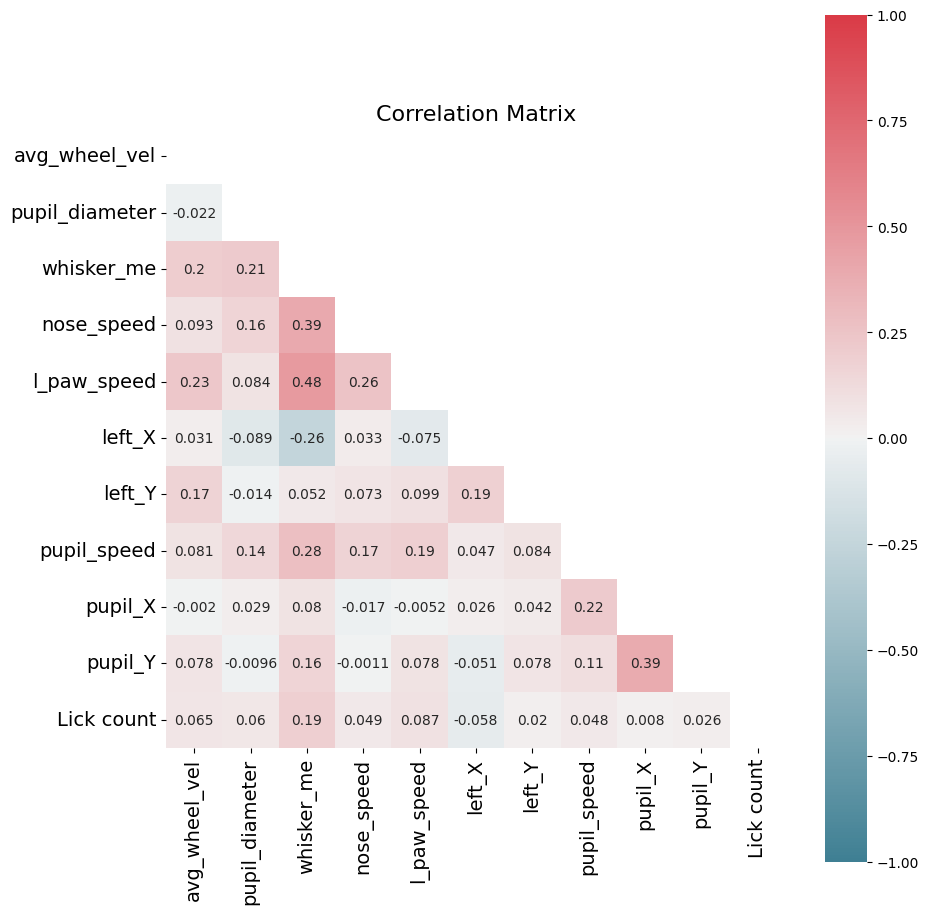

In [112]:
f = plt.figure(figsize=(10, 11))
plt.xticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14, rotation=45)
plt.yticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14)
plt.title('Correlation Matrix', fontsize=16)

matrix = np.triu(cov)

sns.heatmap(cov,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, annot=True, mask=matrix)

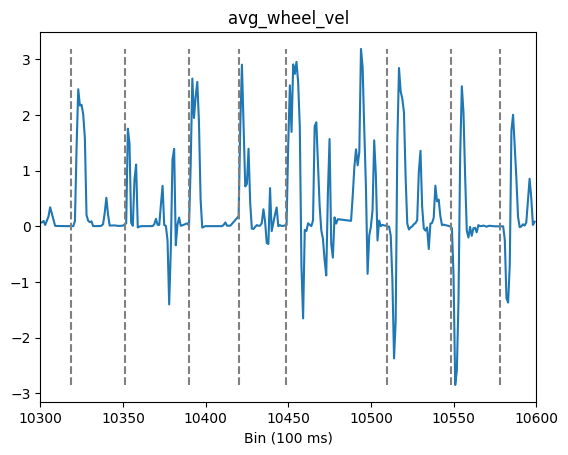

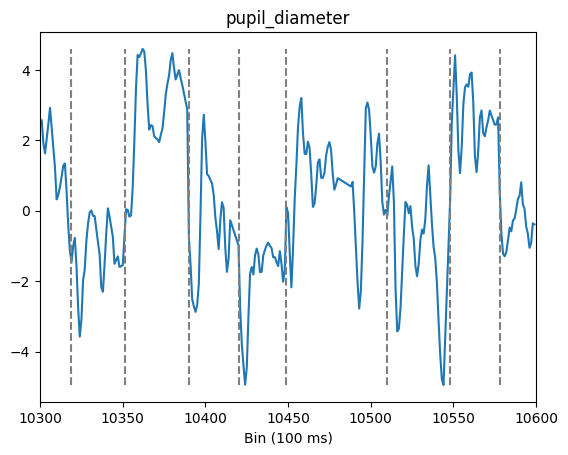

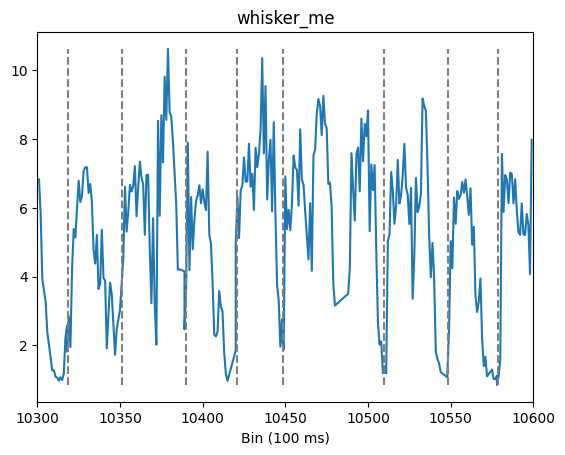

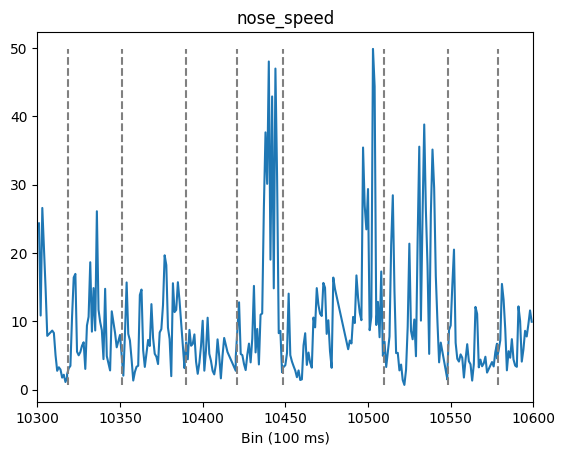

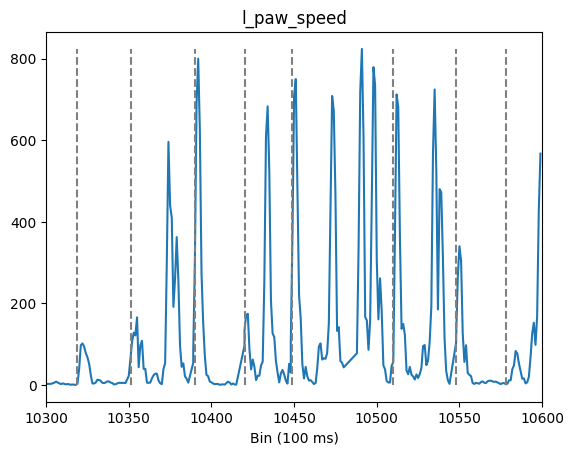

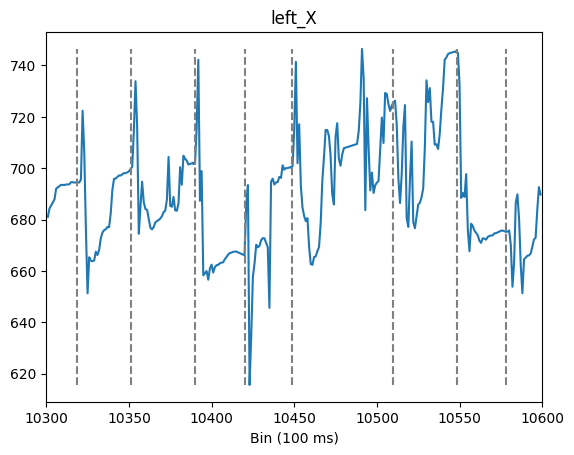

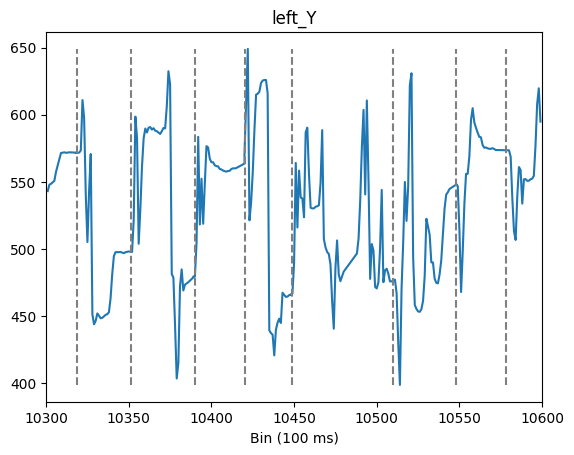

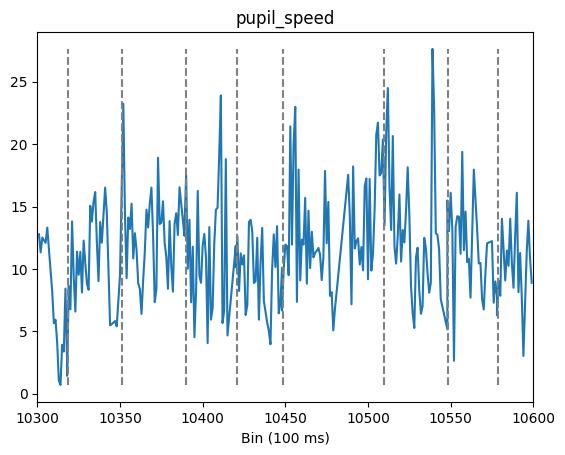

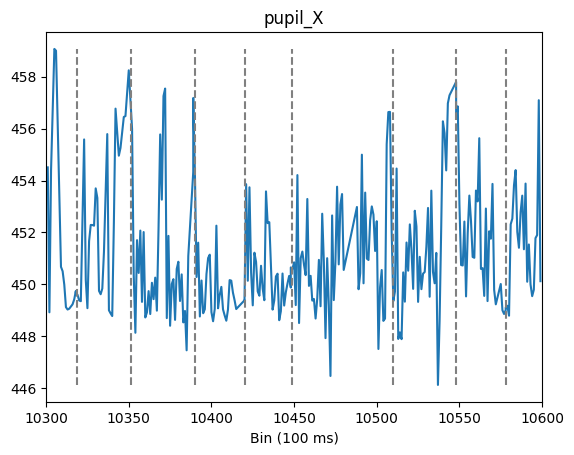

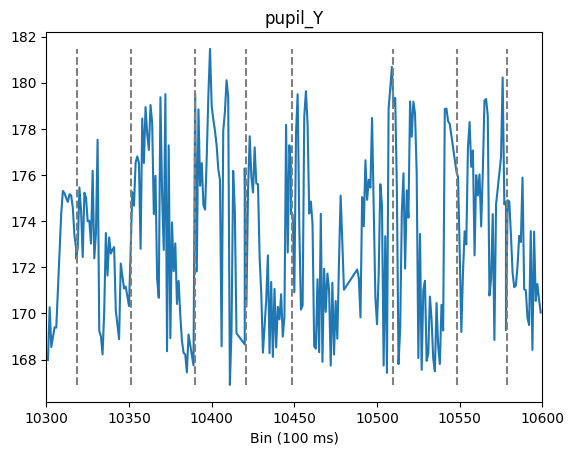

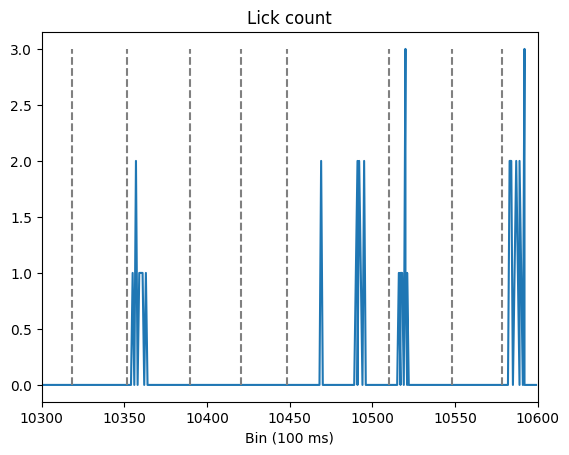

In [14]:

start_point = 10300
end_point =10600

for k, key in enumerate(var_names):
    
    use_data = clean_df.loc[(clean_df['Bin'] > start_point) & (clean_df['Bin'] < end_point)]
    plt.plot(use_data['Bin'], use_data[key])
    plt.xlim([start_point, end_point])
    plt.vlines((use_data['Onset times'].unique() *10), np.min(use_data[key]), np.max(use_data[key]), color='gray', linestyles='--')
    plt.xlabel('Bin (100 ms)')
    plt.title(key)
    plt.show()



(array([1.47306e+05, 3.27010e+04, 2.26660e+04, 1.73000e+04, 5.06800e+03,
        1.00200e+03, 7.00000e+00, 2.64000e+02, 1.00000e+00, 2.00000e+00]),
 array([ 0.48259999,  2.24514334,  4.00768669,  5.77023004,  7.53277339,
         9.29531674, 11.05786009, 12.82040345, 14.5829468 , 16.34549015,
        18.1080335 ]),
 <BarContainer object of 10 artists>)

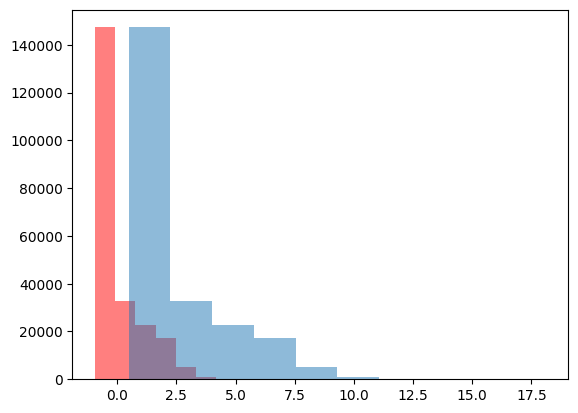

In [20]:
plt.hist(zscore(clean_df['whisker_me']), alpha=0.5, color='red')
plt.hist(clean_df['whisker_me'], alpha=0.5)

In [17]:
clean_df.keys()

Index(['Bin', 'avg_wheel_vel', 'pupil_diameter', 'whisker_me', 'nose_speed',
       'l_paw_speed', 'left_X', 'left_Y', 'pupil_speed', 'pupil_X', 'pupil_Y',
       'Lick count', 'Onset times'],
      dtype='object')

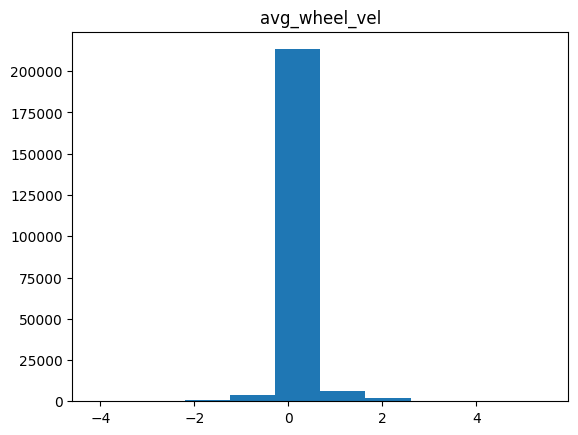

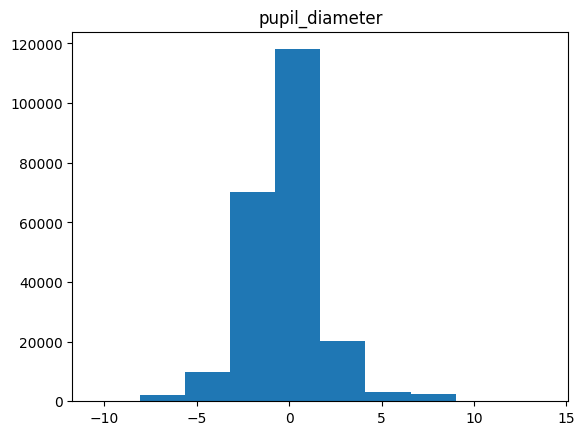

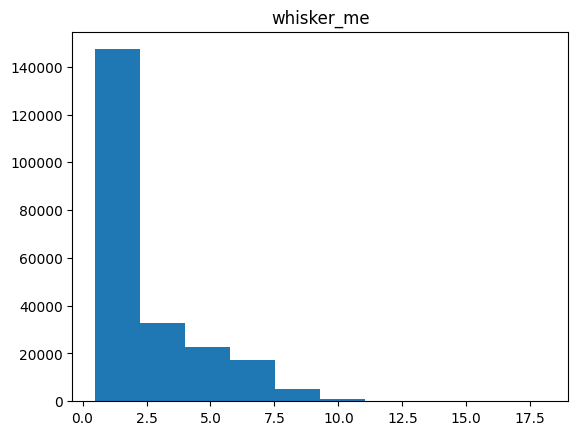

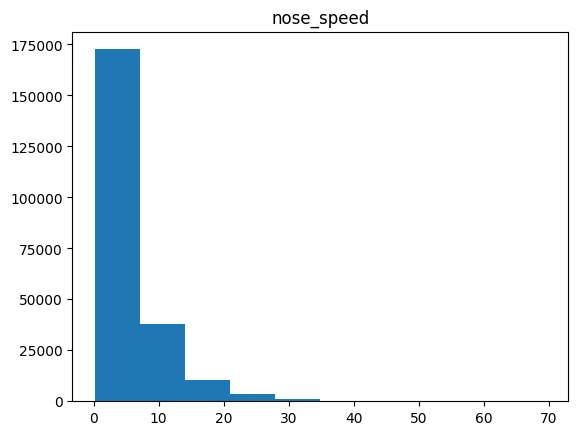

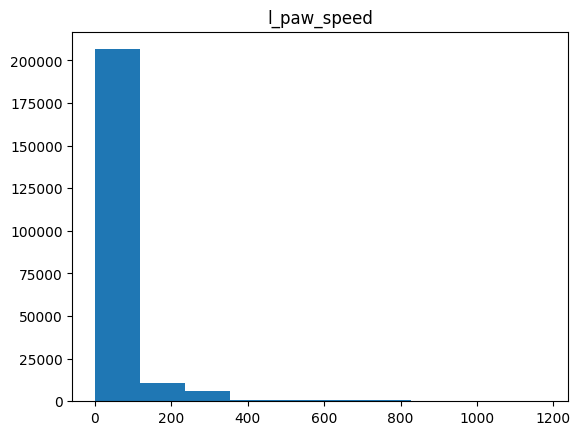

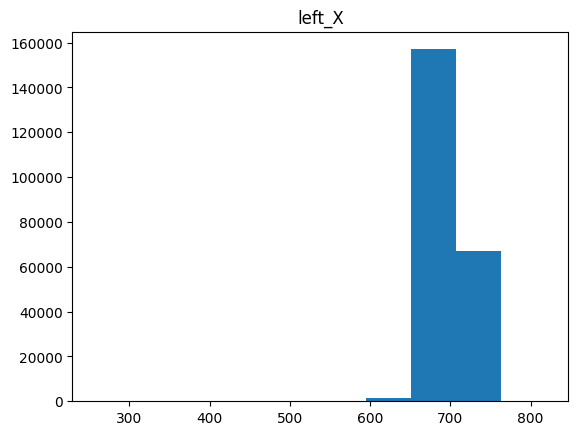

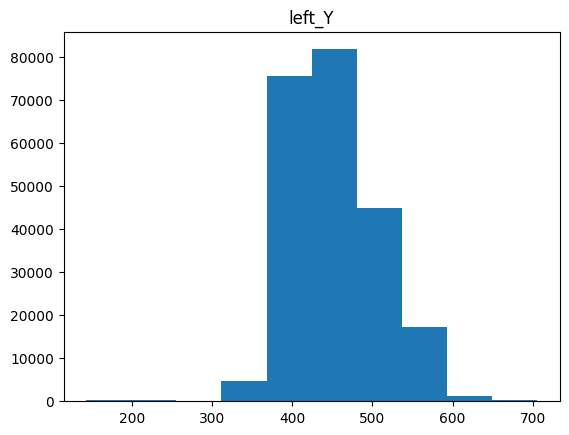

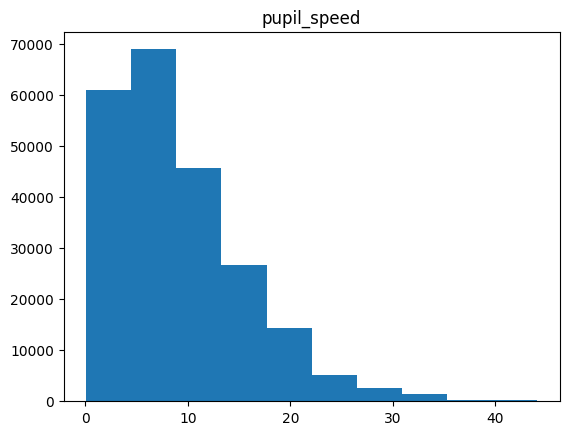

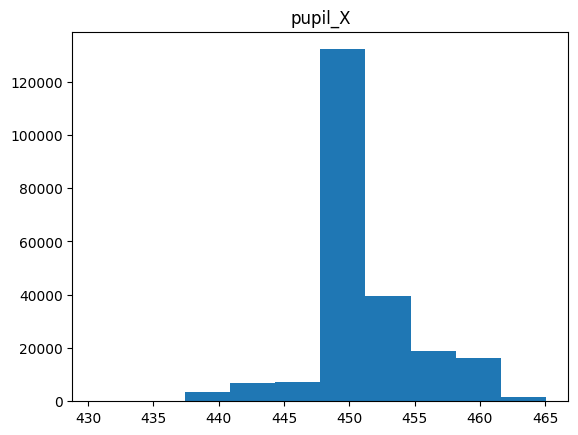

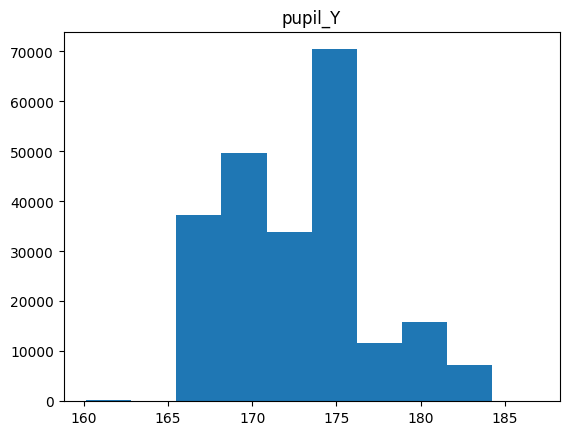

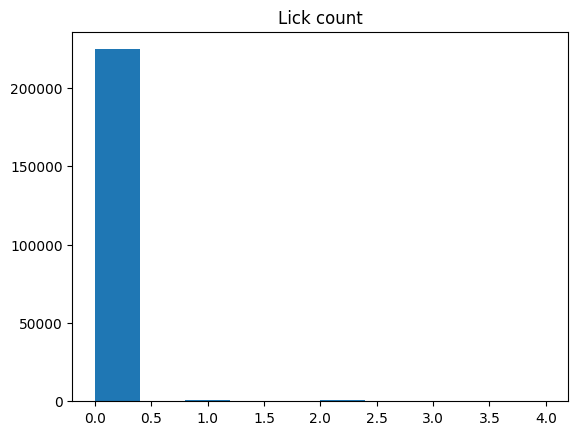

In [15]:

for k, key in enumerate(var_names):
    
    plt.hist(clean_df[key])
    plt.title(key)
    plt.show()
